## Description

### Model

A single LSTM layer was used for this notebook. Here, the model performed best with a dropout of 0.4 and a learning rate of 1e-4. To handle varied sentence lengths pack_padded_sequence was used from the PyTorch library. Early stopping was employed during training.

### Results

The highest accuracy achieved is roughly 63%. Based on the training and validation plots, the model is overfitting on the dataset. This is despite having the lowest hidden dimension and number of layers possible without seeing a further drop in accuracy. This overfitting could be caused by insufficient data, a problem that is often found when attempting to use LSTMs on [small datasets](https://).

### Resources Used:

*   [Multiclass Text Classification using LSTM in Pytorch](https://towardsdatascience.com/multiclass-text-classification-using-lstm-in-pytorch-eac56baed8df)
*   [Build Your First Text Classification model using PyTorch](https://www.analyticsvidhya.com/blog/2020/01/first-text-classification-in-pytorch/)
* [TORCH.NN.UTILS.RNN.PACK_PADDED_SEQUENCE](https://pytorch.org/docs/stable/generated/torch.nn.utils.rnn.pack_padded_sequence.html)



## Imports

In [ ]:
# !pip install torchtext==0.6.0

In [ ]:
import math
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import warnings

import torch
import torch.nn as nn
import torchtext
from torchtext.data import Field, TabularDataset
from torchtext.vocab import Vectors
import torch.nn.functional as F
from torch import nn, optim
from torch.nn.utils.rnn import pack_padded_sequence

warnings.filterwarnings("ignore", category=UserWarning)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Definitions

In [ ]:
batch_size = 16

PATH = "path"
train_path = os.path.join(PATH,"train.csv")
val_path = os.path.join(PATH,"val.csv")
test_path = os.path.join(PATH,"test.csv")

## Data Loaders

In [ ]:
TEXT = Field(sequential=True, lower=True, include_lengths=False, batch_first=True)
LABEL = Field(sequential=False, use_vocab=False)

fields = [('sentence', TEXT), ('label', LABEL)]

In [ ]:
train_data = TabularDataset(
    path=train_path,
    format="csv",
    fields=fields,
    skip_header=True
)

val_data = TabularDataset(
    path=val_path,
    format="csv",
    fields=fields,
    skip_header=True
)

test_data = TabularDataset(
    path=test_path,
    format="csv",
    fields=fields,
    skip_header=True
)

In [ ]:
glove_vectors = torchtext.vocab.GloVe(name="6B", dim=50, max_vectors=50_000)

.vector_cache/glove.6B.zip: 862MB [02:39, 5.39MB/s]                           
100%|█████████▉| 49999/50000 [00:02<00:00, 17260.89it/s]


In [ ]:
TEXT.build_vocab(train_data, vectors=glove_vectors, max_size=50000)
LABEL.build_vocab(train_data)

TEXT.build_vocab(val_data, vectors=glove_vectors, max_size=50000)
LABEL.build_vocab(val_data)

TEXT.build_vocab(test_data, vectors=glove_vectors, max_size=50000)
LABEL.build_vocab(test_data)

In [ ]:
train_iter = torchtext.data.BucketIterator(
    dataset=train_data,
    batch_size=batch_size
)

val_iter = torchtext.data.BucketIterator(
    dataset=val_data,
    batch_size=batch_size
)

test_iter = torchtext.data.BucketIterator(
    dataset=test_data,
    batch_size=batch_size
)

In [ ]:
N_train = 0
N_val = 0
N_test = 0
for x,y in train_iter:
  N_train+=len(x[0])
for x,y in val_iter:
    N_val+=len(x[0])
for x,y in test_iter:
    N_test+=len(x[0])

## Model Definition

In [ ]:
class LSTM_model(torch.nn.Module):
    def __init__(self, embeddings, hidden_dim,dropout = 0.1):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.dropout = nn.Dropout(dropout)
        self.embeddings = nn.Embedding.from_pretrained(embeddings, freeze=False)
        self.lstm = nn.LSTM(embeddings.size(1), hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 2)

    def forward(self, x):
        s = torch.sum(x != 0, dim=1)
        x = self.embeddings(x)
        x = self.dropout(x)
        x_pack = pack_padded_sequence(x, s, batch_first=True, enforce_sorted=False)
        out_pack, (ht, ct) = self.lstm(x_pack)
        out = self.linear(ht[-1])
        return out

In [ ]:
model = LSTM_model(TEXT.vocab.vectors,hidden_dim = 100,dropout=0.4)

In [ ]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(f"Number of parameters in the transformer model: {params}")

Number of parameters in the transformer model: 102352


## Plot Definitions

In [ ]:
def show_performance_curves(training_loss,validation_loss,training_accuracy,validation_accuracy,test_accuracy,last_epoch):

    plt.figure(figsize=(5, 3))
    plt.plot(training_loss[:last_epoch],label='Training',color='g')
    plt.plot(validation_loss[:last_epoch],label='Validation',color='b')
    plt.title('Training and Validation Loss')
    plt.legend(loc='upper right')
    plt.grid()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

    print('Final Training Loss:  ',np.around(training_loss[last_epoch],6))
    print('Final Validation Loss:',np.around(validation_loss[last_epoch],6))

    print("Test Accuracy:", np.around(test_accuracy.item(),4))

    print()

## Training

In [ ]:
epochs = 400
lr = 1e-4

best_val_score = float("-inf")
count_no_improvements = 0
earlyStop = 25
last_epoch = 0

WEIGHTS_PATH = "/lstm.pt"

In [ ]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(),lr=lr)

torch.manual_seed(10)

training_losses = np.zeros(epochs)
val_losses      = np.zeros(epochs)

training_accuracy = np.zeros(epochs)
val_accuracy      = np.zeros(epochs)

for epoch in tqdm(range(epochs)):
    print(f"{epoch=}")
    epoch_loss = 0
    epoch_correct = 0
    epoch_count = 0
    for idx, batch in enumerate(iter(train_iter)):
        predictions = model(batch.sentence.to(device))
        labels = F.one_hot(batch.label, num_classes=2).float().to(device)

        loss = criterion(predictions, labels)

        correct = (torch.argmax(predictions, dim=1) == torch.argmax(labels, dim=1))

        epoch_correct += correct.sum().item()

        epoch_loss += loss.item()

        training_losses[epoch]   = epoch_loss/N_train
        training_accuracy[epoch] = epoch_correct/N_train

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)

        optimizer.step()

    with torch.no_grad():
        val_epoch_loss = 0
        val_epoch_correct = 0

        for idx, batch in enumerate(iter(val_iter)):
            predictions = model(batch.sentence.to(device))
            labels = F.one_hot(batch.label, num_classes=2).float().to(device)
            test_loss = criterion(predictions, labels)

            correct = (torch.argmax(predictions, dim=1) == torch.argmax(labels, dim=1))

            val_epoch_correct += correct.sum().item()
            val_epoch_loss += loss.item()

            val_losses[epoch]   = val_epoch_loss/N_val
            val_accuracy[epoch] = val_epoch_correct/N_val
        if val_accuracy[epoch]>best_val_score:
          best_val_score = val_accuracy[epoch]
          torch.save(model.state_dict(), WEIGHTS_PATH)
          count_no_improvements = 0
        else:
          count_no_improvements+=1
          if count_no_improvements>earlyStop:
            last_epoch = epoch
            break
    print(f"Epoch: {epoch}")
    print(f"Train Loss: {training_losses[epoch]}, Train Accuracy: {training_accuracy[epoch]}")
    print(f"Validation Loss: {val_losses[epoch]}, Validation Accuracy: {val_accuracy[epoch]}")
    last_epoch = epoch

  0%|          | 0/400 [00:00<?, ?it/s]

epoch=0


  0%|          | 1/400 [00:01<09:36,  1.44s/it]

Epoch: 0
Train Loss: 0.04325129691759745, Train Accuracy: 0.6133333333333333
Validation Loss: 0.04419277560326361, Validation Accuracy: 0.6236559139784946
epoch=1


  0%|          | 2/400 [00:02<07:36,  1.15s/it]

Epoch: 1
Train Loss: 0.042575071175893146, Train Accuracy: 0.6186666666666667
Validation Loss: 0.04520168996626331, Validation Accuracy: 0.6236559139784946
epoch=2


  1%|          | 3/400 [00:03<06:56,  1.05s/it]

Epoch: 2
Train Loss: 0.041490902503331505, Train Accuracy: 0.6186666666666667
Validation Loss: 0.04540624157074959, Validation Accuracy: 0.6236559139784946
epoch=3


  1%|          | 4/400 [00:04<06:41,  1.01s/it]

Epoch: 3
Train Loss: 0.04081108069419861, Train Accuracy: 0.6186666666666667
Validation Loss: 0.03707670780920213, Validation Accuracy: 0.6236559139784946
epoch=4


  1%|▏         | 5/400 [00:05<06:32,  1.01it/s]

Epoch: 4
Train Loss: 0.04057902415593465, Train Accuracy: 0.62
Validation Loss: 0.04623123138181625, Validation Accuracy: 0.6236559139784946
epoch=5


  2%|▏         | 6/400 [00:06<06:24,  1.02it/s]

Epoch: 5
Train Loss: 0.04040043691794078, Train Accuracy: 0.624
Validation Loss: 0.03629862493084323, Validation Accuracy: 0.6236559139784946
epoch=6


  2%|▏         | 7/400 [00:07<06:17,  1.04it/s]

Epoch: 6
Train Loss: 0.039259111205736795, Train Accuracy: 0.624
Validation Loss: 0.04537696607651249, Validation Accuracy: 0.6236559139784946
epoch=7


  2%|▏         | 8/400 [00:08<06:13,  1.05it/s]

Epoch: 7
Train Loss: 0.03915587119261424, Train Accuracy: 0.632
Validation Loss: 0.03968726050469183, Validation Accuracy: 0.6344086021505376
epoch=8


  2%|▏         | 9/400 [00:08<06:06,  1.07it/s]

Epoch: 8
Train Loss: 0.03879690738519033, Train Accuracy: 0.628
Validation Loss: 0.037688032273323305, Validation Accuracy: 0.6451612903225806
epoch=9


  2%|▎         | 10/400 [00:10<06:48,  1.05s/it]

Epoch: 9
Train Loss: 0.03752453295389811, Train Accuracy: 0.6333333333333333
Validation Loss: 0.04610192006634128, Validation Accuracy: 0.6236559139784946
epoch=10


  3%|▎         | 11/400 [00:11<07:17,  1.13s/it]

Epoch: 10
Train Loss: 0.038084831237792965, Train Accuracy: 0.6386666666666667
Validation Loss: 0.042352203399904316, Validation Accuracy: 0.6236559139784946
epoch=11


  3%|▎         | 12/400 [00:12<07:34,  1.17s/it]

Epoch: 11
Train Loss: 0.03844050780932109, Train Accuracy: 0.6386666666666667
Validation Loss: 0.04299068066381639, Validation Accuracy: 0.6451612903225806
epoch=12


  3%|▎         | 13/400 [00:14<07:48,  1.21s/it]

Epoch: 12
Train Loss: 0.037639877239863076, Train Accuracy: 0.6586666666666666
Validation Loss: 0.026570802734744166, Validation Accuracy: 0.6559139784946236
epoch=13


  4%|▎         | 14/400 [00:15<07:12,  1.12s/it]

Epoch: 13
Train Loss: 0.03789821084340413, Train Accuracy: 0.656
Validation Loss: 0.03933483939017019, Validation Accuracy: 0.6451612903225806
epoch=14


  4%|▍         | 15/400 [00:15<06:50,  1.07s/it]

Epoch: 14
Train Loss: 0.03816741065184275, Train Accuracy: 0.6573333333333333
Validation Loss: 0.03442471258101925, Validation Accuracy: 0.6344086021505376
epoch=15


  4%|▍         | 16/400 [00:16<06:33,  1.02s/it]

Epoch: 15
Train Loss: 0.03650624950726827, Train Accuracy: 0.6853333333333333
Validation Loss: 0.02933441823528659, Validation Accuracy: 0.6344086021505376
epoch=16


  4%|▍         | 17/400 [00:17<06:21,  1.00it/s]

Epoch: 16
Train Loss: 0.03743736720085144, Train Accuracy: 0.7053333333333334
Validation Loss: 0.03941602860727618, Validation Accuracy: 0.6344086021505376
epoch=17


  4%|▍         | 18/400 [00:18<06:11,  1.03it/s]

Epoch: 17
Train Loss: 0.036966267426808676, Train Accuracy: 0.6693333333333333
Validation Loss: 0.03217661380767822, Validation Accuracy: 0.5591397849462365
epoch=18


  5%|▍         | 19/400 [00:19<06:03,  1.05it/s]

Epoch: 18
Train Loss: 0.036620368123054504, Train Accuracy: 0.6906666666666667
Validation Loss: 0.04501721551341395, Validation Accuracy: 0.5698924731182796
epoch=19


  5%|▌         | 20/400 [00:20<05:59,  1.06it/s]

Epoch: 19
Train Loss: 0.036121947964032494, Train Accuracy: 0.708
Validation Loss: 0.03871322447253812, Validation Accuracy: 0.6451612903225806
epoch=20


  5%|▌         | 21/400 [00:21<05:56,  1.06it/s]

Epoch: 20
Train Loss: 0.03501287082831065, Train Accuracy: 0.6906666666666667
Validation Loss: 0.038486303821686774, Validation Accuracy: 0.6344086021505376
epoch=21


  6%|▌         | 22/400 [00:22<05:50,  1.08it/s]

Epoch: 21
Train Loss: 0.03534495969613393, Train Accuracy: 0.7013333333333334
Validation Loss: 0.03057211829769996, Validation Accuracy: 0.5806451612903226
epoch=22


  6%|▌         | 23/400 [00:23<05:49,  1.08it/s]

Epoch: 22
Train Loss: 0.035358609080314636, Train Accuracy: 0.708
Validation Loss: 0.03421028198734406, Validation Accuracy: 0.6881720430107527
epoch=23


  6%|▌         | 24/400 [00:24<05:53,  1.06it/s]

Epoch: 23
Train Loss: 0.03506116958459218, Train Accuracy: 0.7093333333333334
Validation Loss: 0.03388318323319958, Validation Accuracy: 0.6129032258064516
epoch=24


  6%|▋         | 25/400 [00:25<06:34,  1.05s/it]

Epoch: 24
Train Loss: 0.034125430504481, Train Accuracy: 0.712
Validation Loss: 0.026818023573967717, Validation Accuracy: 0.6666666666666666
epoch=25


  6%|▋         | 26/400 [00:26<07:01,  1.13s/it]

Epoch: 25
Train Loss: 0.03404400755961736, Train Accuracy: 0.7106666666666667
Validation Loss: 0.04747306531475436, Validation Accuracy: 0.6129032258064516
epoch=26


  7%|▋         | 27/400 [00:28<07:17,  1.17s/it]

Epoch: 26
Train Loss: 0.034783709168434145, Train Accuracy: 0.72
Validation Loss: 0.04310401024356965, Validation Accuracy: 0.6236559139784946
epoch=27


  7%|▋         | 28/400 [00:29<07:19,  1.18s/it]

Epoch: 27
Train Loss: 0.03394499472777049, Train Accuracy: 0.7306666666666667
Validation Loss: 0.048289222102011406, Validation Accuracy: 0.6344086021505376
epoch=28


  7%|▋         | 29/400 [00:30<06:49,  1.10s/it]

Epoch: 28
Train Loss: 0.03426650210221609, Train Accuracy: 0.7306666666666667
Validation Loss: 0.050378876347695625, Validation Accuracy: 0.6344086021505376
epoch=29


  8%|▊         | 30/400 [00:31<06:25,  1.04s/it]

Epoch: 29
Train Loss: 0.03451208317279816, Train Accuracy: 0.7133333333333334
Validation Loss: 0.040530208618410175, Validation Accuracy: 0.6344086021505376
epoch=30


  8%|▊         | 31/400 [00:32<06:09,  1.00s/it]

Epoch: 30
Train Loss: 0.03407339032491048, Train Accuracy: 0.72
Validation Loss: 0.051840159200852914, Validation Accuracy: 0.6344086021505376
epoch=31


  8%|▊         | 32/400 [00:33<06:00,  1.02it/s]

Epoch: 31
Train Loss: 0.03370276002089183, Train Accuracy: 0.724
Validation Loss: 0.02963894990182692, Validation Accuracy: 0.6774193548387096
epoch=32


  8%|▊         | 33/400 [00:34<05:56,  1.03it/s]

Epoch: 32
Train Loss: 0.03344983645280202, Train Accuracy: 0.7253333333333334
Validation Loss: 0.026173424336218064, Validation Accuracy: 0.6129032258064516
epoch=33


  8%|▊         | 34/400 [00:34<05:48,  1.05it/s]

Epoch: 33
Train Loss: 0.033679981390635175, Train Accuracy: 0.7133333333333334
Validation Loss: 0.0215559063419219, Validation Accuracy: 0.6344086021505376
epoch=34


  9%|▉         | 35/400 [00:35<05:43,  1.06it/s]

Epoch: 34
Train Loss: 0.032594265580177306, Train Accuracy: 0.728
Validation Loss: 0.032833960748487906, Validation Accuracy: 0.6451612903225806
epoch=35


  9%|▉         | 36/400 [00:36<05:39,  1.07it/s]

Epoch: 35
Train Loss: 0.03289397716522217, Train Accuracy: 0.7413333333333333
Validation Loss: 0.029387512514668125, Validation Accuracy: 0.6774193548387096
epoch=36


  9%|▉         | 37/400 [00:37<05:39,  1.07it/s]

Epoch: 36
Train Loss: 0.03382463073730469, Train Accuracy: 0.744
Validation Loss: 0.033973520801913355, Validation Accuracy: 0.6344086021505376
epoch=37


 10%|▉         | 38/400 [00:38<05:41,  1.06it/s]

Epoch: 37
Train Loss: 0.03260887444019318, Train Accuracy: 0.744
Validation Loss: 0.03031578948420863, Validation Accuracy: 0.6451612903225806
epoch=38


 10%|▉         | 39/400 [00:39<06:04,  1.01s/it]

Epoch: 38
Train Loss: 0.03404409158229828, Train Accuracy: 0.744
Validation Loss: 0.033109876417344614, Validation Accuracy: 0.6451612903225806
epoch=39


 10%|█         | 40/400 [00:41<06:37,  1.10s/it]

Epoch: 39
Train Loss: 0.032661041498184204, Train Accuracy: 0.752
Validation Loss: 0.027646214731277957, Validation Accuracy: 0.6559139784946236
epoch=40


 10%|█         | 41/400 [00:42<07:00,  1.17s/it]

Epoch: 40
Train Loss: 0.03254040547211965, Train Accuracy: 0.76
Validation Loss: 0.0331785794227354, Validation Accuracy: 0.6236559139784946
epoch=41


 10%|█         | 42/400 [00:43<07:15,  1.22s/it]

Epoch: 41
Train Loss: 0.03173978992303213, Train Accuracy: 0.7653333333333333
Validation Loss: 0.025563859170483004, Validation Accuracy: 0.6881720430107527
epoch=42


 11%|█         | 43/400 [00:44<06:55,  1.16s/it]

Epoch: 42
Train Loss: 0.031962043325106305, Train Accuracy: 0.7573333333333333
Validation Loss: 0.03169199728196667, Validation Accuracy: 0.6774193548387096
epoch=43


 11%|█         | 44/400 [00:45<06:31,  1.10s/it]

Epoch: 43
Train Loss: 0.03338179749250412, Train Accuracy: 0.7293333333333333
Validation Loss: 0.04111814498901367, Validation Accuracy: 0.6021505376344086
epoch=44


 11%|█▏        | 45/400 [00:46<06:09,  1.04s/it]

Epoch: 44
Train Loss: 0.03172345411777496, Train Accuracy: 0.756
Validation Loss: 0.012292871552128945, Validation Accuracy: 0.6344086021505376
epoch=45


 12%|█▏        | 46/400 [00:47<05:59,  1.02s/it]

Epoch: 45
Train Loss: 0.032271152297655745, Train Accuracy: 0.7546666666666667
Validation Loss: 0.01890500130191926, Validation Accuracy: 0.6236559139784946
epoch=46


 12%|█▏        | 47/400 [00:48<05:50,  1.01it/s]

Epoch: 46
Train Loss: 0.0323620091676712, Train Accuracy: 0.7493333333333333
Validation Loss: 0.04389333724975586, Validation Accuracy: 0.6236559139784946
epoch=47


 12%|█▏        | 48/400 [00:49<05:45,  1.02it/s]

Epoch: 47
Train Loss: 0.03208716823657354, Train Accuracy: 0.752
Validation Loss: 0.030144885663063295, Validation Accuracy: 0.5806451612903226
epoch=48


 12%|█▏        | 48/400 [00:50<06:10,  1.05s/it]


## Testing

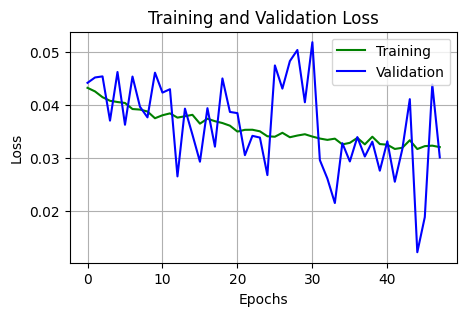

Final Training Loss:   0.031556
Final Validation Loss: 0.012925
Test Accuracy: 0.625



In [ ]:
num_correct_test = 0
evalModel = model
evalModel.load_state_dict(torch.load(WEIGHTS_PATH))
evalModel.eval()

test_loss = 0
test_correct = 0

for idx, batch in enumerate(iter(test_iter)):
  predictions = model(batch.sentence.to(device))
  labels = F.one_hot(batch.label, num_classes=2).float().to(device)
  test_loss = criterion(predictions, labels)

  correct = (torch.argmax(predictions, dim=1) == torch.argmax(labels, dim=1))

  test_correct += correct.sum()
  test_loss += loss.item()

  val_losses[epoch]   = test_loss/N_val
  val_accuracy[epoch] = test_correct/N_val

test_accuracy = test_correct / N_test

show_performance_curves(training_losses,val_losses,training_accuracy,val_accuracy,test_accuracy,last_epoch)